Passband Luminosity
============================

Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.2 installed. (You can comment out this line if you don't use pip for your installation or don't want to update to the latest release).

In [ ]:
!pip install -I "phoebe>=2.2,<2.3"

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](building_a_system.ipynb) for more details.

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u # units
import numpy as np

logger = phoebe.logger()

b = phoebe.default_binary()

And we'll add a single light curve dataset so that we can see how passband luminosities affect the resulting synthetic light curve model.

In [3]:
b.add_dataset('lc', times=phoebe.linspace(0,1,101), dataset='lc01')

<ParameterSet: 43 parameters | contexts: figure, compute, constraint, dataset>

Lastly, just to make things a bit easier and faster, we'll turn off [irradiation (reflection)](reflection_heating.ipynb), use blackbody atmospheres, and disable [limb-darkening](limb_darkening.ipynb) (so that we can play with weird temperatures without having to worry about falling of the grids).

In [4]:
b.set_value('irrad_method', 'none')
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_func', 'linear')
b.set_value_all('ld_coeffs', [0.])
b.set_value_all('ld_mode_bol', 'manual')
b.set_value_all('ld_func_bol', 'linear')
b.set_value_all('ld_coeffs_bol', [0.])
b.set_value_all('atm', 'blackbody')

Relevant Parameters & Methods
--------------------------------

**NEW in PHOEBE 2.2:** A `pblum_mode` parameter exists for each LC dataset in the bundle.  This parameter defines how passband luminosities are handled.  The subsections below describe the use and parameters exposed depening on the value of this parameter.

In [5]:
print(b.get_parameter(qualifier='pblum_mode', dataset='lc01'))

Parameter: pblum_mode@lc01@dataset
                       Qualifier: pblum_mode
                     Description: Mode for scaling passband luminosities
                           Value: component-coupled
                         Choices: decoupled, component-coupled, dataset-coupled, dataset-scaled, absolute
                  Constrained by: 
                      Constrains: None
                      Related to: None



For any of these modes, you can expose the intrinsic (excluding extrinsic effects such as [spots](./spots.ipynb) and [irradiation](./reflection_heating.ipynb)) and extrinsic computed luminosities of each star (in each dataset) by calling [b.compute_pblums](../api/phoebe.frontend.bundle.Bundle.compute_pblums.md).

Note that as its an aspect-dependent effect, [boosting](boosting.ipynb) is ignored in all of these output values.

In [6]:
print(b.compute_pblums())

{'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@secondary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 12.56637061 W>}


For more details, see the section below on "Accessing Model Luminosities" as well as the [b.compute_pblums API docs](../api/phoebe.frontend.bundle.Bundle.compute_pblums.md)

pblum_mode = 'component-coupled'
-----------------------



`pblum_mode='component-coupled'` is the default option and maintains the default behavior from previous releases.  Here the user provides *passband luminosities* for a single star in the system for the given dataset/passband, and all other stars are scaled accordingly.

By default, the value of `pblum` is set for the primary star in the system, but we can instead provide `pblum` for the secondary star by changing the value of `pblum_component`.

In [7]:
print(b.filter(qualifier='pblum'))

ParameterSet: 1 parameters
      pblum@primary@lc01@dataset: 12.566370614359172 W


In [8]:
print(b.get_parameter(qualifier='pblum_component'))

Parameter: pblum_component@lc01@dataset
                       Qualifier: pblum_component
                     Description: Which component's pblum will be provided
                           Value: primary
                         Choices: primary, secondary
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: pblum_mode:component-coupled



In [9]:
b.set_value('pblum_component', 'secondary')

In [10]:
print(b.filter(qualifier='pblum'))

ParameterSet: 1 parameters
    pblum@secondary@lc01@dataset: 12.566370614359172 W


Note that in general (for the case of a spherical star), a pblum of 4pi will result in an out-of-eclipse flux of ~1.

Now let's just reset to the default case where the primary star has a provided (default) pblum of 4pi.

In [11]:
b.set_value('pblum_component', 'primary')
print(b.get_parameter(qualifier='pblum', component='primary'))

Parameter: pblum@primary@lc01@dataset
                       Qualifier: pblum
                     Description: Passband luminosity (defined at t0)
                           Value: 12.566370614359172 W
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: [component]pblum_mode:decoupled||[component]pblum_mode:component-coupled,[component]pblum_component:<component>



**NOTE:** other parameters also affect flux-levels, including [limb darkening](limb_darkening.ipynb), [third light](l3.ipynb), [boosting](boosting.ipynb), [irradiation](reflection_heating.ipynb), and [distance](distance.ipynb)

If we call [b.compute_pblums](../api/phoebe.frontend.bundle.Bundle.compute_pblums.md), we'll see that the computed intrinsic luminosity of the primary star (pblum@primary@lc01) matches the value of the parameter above.

In [12]:
print(b.compute_pblums())

{'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@secondary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 12.56637061 W>}


Let's see how changing the value of pblum affects the computed light curve.  By default, pblum is set to be 4 pi, giving a total flux for the primary star of ~1.

Since the secondary star in the default binary is identical to the primary star, we'd expect an out-of-eclipse flux of the binary to be ~2.

In [13]:
b.run_compute()

<ParameterSet: 4 parameters | contexts: model, figure>

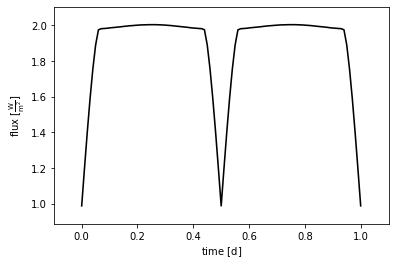

In [14]:
afig, mplfig = b.plot(show=True)

If we now set pblum to be only 2 pi, we should expect the luminosities as well as entire light curve to be scaled in half.

In [15]:
b.set_value('pblum', component='primary', value=2*np.pi)

In [16]:
print(b.compute_pblums())

{'pblum_ext@primary@lc01': <Quantity 6.28318531 W>, 'pblum_ext@secondary@lc01': <Quantity 6.28318531 W>, 'pblum@primary@lc01': <Quantity 6.28318531 W>, 'pblum@secondary@lc01': <Quantity 6.28318531 W>}


In [17]:
b.run_compute()

Wed, 11 Dec 2019 16:32 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 4 parameters | contexts: model, figure>

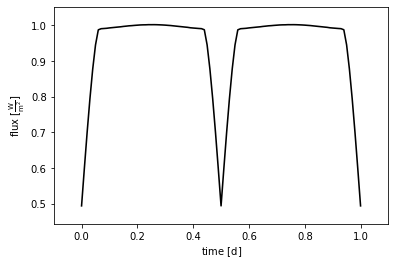

In [18]:
afig, mplfig = b.plot(show=True)

And if we halve the temperature of the secondary star - the resulting light curve changes to the new sum of fluxes, where the primary star dominates since the secondary star flux is reduced by a factor of 16, so we expect a total out-of-eclipse flux of ~0.5 + ~0.5/16 = ~0.53.

In [19]:
b.set_value('teff', component='secondary', value=0.5 * b.get_value('teff', component='primary'))

In [20]:
print(b.filter(qualifier='teff'))

ParameterSet: 2 parameters
          teff@primary@component: 6000.0 K
        teff@secondary@component: 3000.0 K


In [21]:
print(b.compute_pblums())

{'pblum_ext@primary@lc01': <Quantity 6.28318531 W>, 'pblum_ext@secondary@lc01': <Quantity 0.07936613 W>, 'pblum@primary@lc01': <Quantity 6.28318531 W>, 'pblum@secondary@lc01': <Quantity 0.07936613 W>}


In [22]:
b.run_compute()

Wed, 11 Dec 2019 16:32 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 4 parameters | contexts: model, figure>

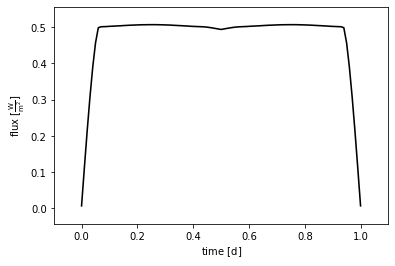

In [23]:
afig, mplfig = b.plot(show=True)

Let us undo our changes before we look at decoupled luminosities.

In [24]:
b.set_value_all('teff', 6000)
b.set_value_all('pblum', 4*np.pi)

pblum_mode = 'decoupled'
---------------------

The luminosities are decoupled when pblums are provided for the individual components.  To accomplish this, set `pblum_mode` to 'decoupled'.

In [25]:
b.set_value('pblum_mode', 'decoupled')

Now we see that both `pblum` parameters are available and can have different values.

In [26]:
print(b.filter(qualifier='pblum'))

ParameterSet: 2 parameters
      pblum@primary@lc01@dataset: 12.566370614359172 W
    pblum@secondary@lc01@dataset: 12.566370614359172 W


If we set these to 4pi, then we'd expect each star to contribute 1.0 in flux units, meaning the baseline of the light curve should be at approximately 2.0

In [27]:
b.set_value_all('pblum', 4*np.pi)

In [28]:
print(b.compute_pblums())

{'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@secondary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 12.56637061 W>}


In [29]:
b.run_compute()

Wed, 11 Dec 2019 16:32 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 4 parameters | contexts: model, figure>

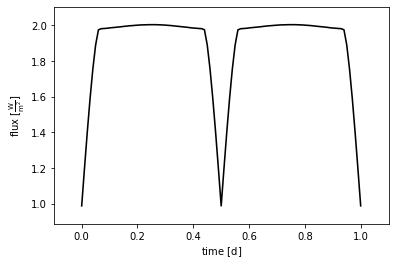

In [30]:
afig, mplfig = b.plot(show=True)

Now let's make a significant temperature-ratio by making a very cool secondary star.  Since the luminosities are decoupled - this temperature change won't affect the resulting light curve very much (compare this to the case above with coupled luminosities).  What is happening here is that even though the secondary star is *cooler*, its luminosity is being rescaled to the same value as the primary star, so the eclipse depth doesn't change (you would see a similar lack-of-effect if you changed the radii - although in that case the eclipse widths would still change due to the change in geometry).

In [31]:
print(b.filter(qualifier='teff'))

ParameterSet: 2 parameters
          teff@primary@component: 6000.0 K
        teff@secondary@component: 6000.0 K


In [32]:
b.set_value('teff', component='secondary', value=3000)

In [33]:
print(b.compute_pblums())

{'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@secondary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 12.56637061 W>}


In [34]:
b.run_compute()

Wed, 11 Dec 2019 16:32 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 4 parameters | contexts: model, figure>

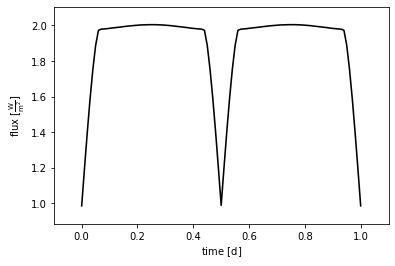

In [35]:
afig, mplfig = b.plot(show=True)

In most cases you will *not want* decoupled luminosities as they can easily break the self-consistency of your model.

Now we'll just undo our changes before we look at accessing model luminosities.

In [36]:
b.set_value_all('teff', 6000)
b.set_value_all('pblum', 4*np.pi)

pblum_mode = 'absolute'
-----------------------------------

By setting `pblum_mode` to 'absolute', luminosities and fluxes will be returned in absolute units and not rescaled.  Note that [third light](l3) and [distance](distance) will still affect the resulting flux levels.

In [37]:
b.set_value('pblum_mode', 'absolute')

As we no longer provide pblum values to scale, those parameters are not visible when filtering.

In [38]:
print(b.filter(qualifier='pblum'))

ParameterSet: 0 parameters
NO PARAMETERS


In [39]:
print(b.compute_pblums())

{'pblum_ext@primary@lc01': <Quantity 4.99137789e+25 W>, 'pblum_ext@secondary@lc01': <Quantity 4.99137789e+25 W>, 'pblum@primary@lc01': <Quantity 4.99137789e+25 W>, 'pblum@secondary@lc01': <Quantity 4.99137789e+25 W>}


In [40]:
b.run_compute()

Wed, 11 Dec 2019 16:32 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 4 parameters | contexts: model, figure>

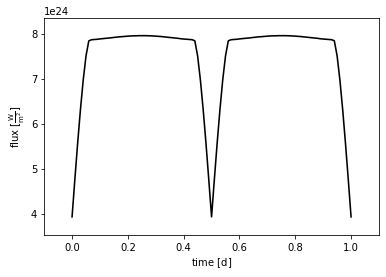

In [41]:
afig, mplfig = b.plot(show=True)

(note the exponent on the y-axis of the above figure)

pblum_mode = 'dataset-scaled'
----------------------------------

Setting `pblum_mode` to 'dataset-sclaed' is only allowed if fluxes are attached to the dataset itself.  Let's use our existing model to generate "fake" data and then populate the dataset.

In [42]:
fluxes = b.get_value('fluxes', context='model') * 0.8 + (np.random.random(101) * 0.1)

In [43]:
b.set_value('fluxes', context='dataset', value=fluxes)

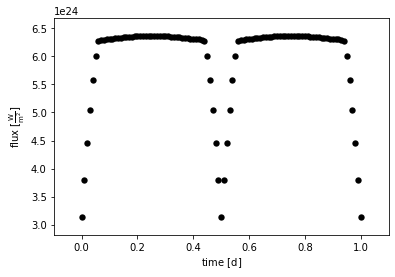

In [44]:
afig, mplfig = b.plot(context='dataset', show=True)

Now if we set `pblum_mode` to 'dataset-scaled', the resulting model will be scaled to best fit the data.  Note that in this mode we cannot access computed luminosities via [b.compute_pblums](../api/phoebe.frontend.bundle.Bundle.compute_pblums.md) (which would raise an error if we attempted to do so), nor can we access scaled intensities from the mesh.

In [45]:
b.set_value('pblum_mode', 'dataset-scaled')

In [46]:
print(b.compute_pblums())

Wed, 11 Dec 2019 16:32 BUNDLE       WARNING cannot expose pblum for dataset=lc01 with pblum_mode@lc01='dataset-scaled'


{}


In [47]:
b.run_compute()

Wed, 11 Dec 2019 16:32 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 4 parameters | contexts: model, figure>

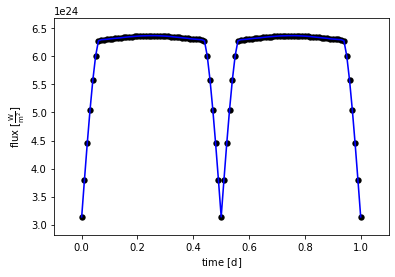

In [48]:
afig, mplfig = b.plot(show=True)

Before moving on, let's remove our fake data (and reset `pblum_mode` or else PHOEBE will complain about the lack of data).

In [49]:
b.set_value('pblum_mode', 'component-coupled')

In [50]:
b.set_value('fluxes', context='dataset', value=[])

pblum_mode = 'dataset-coupled'
--------------------------------

Setting `pblum_mode` to 'dataset-coupled' allows for the same scaling factor to be applied to two different datasets.  In order to see this in action, we'll add another LC dataset in a different passband.

In [51]:
b.add_dataset('lc', times=phoebe.linspace(0,1,101), 
              ld_mode='manual', ld_func='linear', ld_coeffs=[0],
              passband='Johnson:B', dataset='lc02')

Wed, 11 Dec 2019 16:32 BUNDLE       WARNING downloading and installing Johnson:B passband with content=['blackbody:Inorm']


<ParameterSet: 43 parameters | contexts: figure, compute, constraint, dataset>

In [52]:
b.set_value('pblum_mode', dataset='lc02', value='dataset-coupled')

Here we see the pblum\_mode@lc01 is set to 'component-coupled' meaning it will follow the rules described earlier where `pblum` is provided for the primary component and the secondary is coupled to that.  pblum\_mode@lc02 is set to 'dataset-coupled' with pblum_dataset@lc01 pointing to 'lc01'.

In [53]:
print(b.filter('pblum*'))

ParameterSet: 5 parameters
         pblum_mode@lc01@dataset: component-coupled
    pblum_component@lc01@dataset: primary
      pblum@primary@lc01@dataset: 12.566370614359172 W
         pblum_mode@lc02@dataset: dataset-coupled
      pblum_dataset@lc02@dataset: lc01


In [54]:
print(b.compute_pblums())

{'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@secondary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@primary@lc02': <Quantity 13.42664331 W>, 'pblum_ext@secondary@lc02': <Quantity 13.42664331 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc02': <Quantity 13.42664331 W>, 'pblum@secondary@lc02': <Quantity 13.42664331 W>}


In [55]:
b.run_compute()

Wed, 11 Dec 2019 16:32 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 6 parameters | contexts: model, figure>

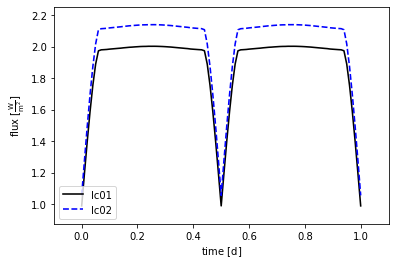

In [56]:
afig, mplfig = b.plot(show=True, legend=True)

Accessing Model Luminosities
-----------------------------------

Passband luminosities at t0@system per-star (including following all coupling logic) can be computed and exposed on the fly by calling `compute_pblums`.

In [58]:
print(b.compute_pblums())

{'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@secondary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@primary@lc02': <Quantity 13.42664331 W>, 'pblum_ext@secondary@lc02': <Quantity 13.42664331 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc02': <Quantity 13.42664331 W>, 'pblum@secondary@lc02': <Quantity 13.42664331 W>}


By default this exposes 'pblum' and 'pblum_ext' for all component-dataset pairs in the form of a dictionary.  Alternatively, you can pass a label or list of labels to component and/or dataset.

In [59]:
print(b.compute_pblums(dataset='lc01', component='primary'))

{'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>}


For more options, see the [b.compute_pblums API docs](../api/phoebe.frontend.bundle.Bundle.compute_pblums.md).

Note that this same logic is applied (at t0) to initialize all passband luminosities within the backend, so there is no need to call `compute_pblums` before `run_compute`.

In order to access passband luminosities at times other than t0, you can add a mesh dataset and request the `pblum_ext` column to be exposed.  For stars that have pblum defined (as opposed to coupled to another star or dataset), this value should be equivalent to the value of the parameter (at t0 if no features or irradiation are present, and in simple circular cases will probably be equivalent at all times).

Let's create a mesh dataset at a few times and then access the synthetic luminosities.

In [60]:
b.add_dataset('mesh', times=np.linspace(0,1,5), dataset='mesh01', columns=['areas', 'pblum_ext@lc01', 'ldint@lc01', 'ptfarea@lc01', 'abs_normal_intensities@lc01', 'normal_intensities@lc01'])

Wed, 11 Dec 2019 16:32 BUNDLE       WARNING mesh dataset uses 'compute_times' instead of 'times', applying value sent as 'times' to 'compute_times'.


<ParameterSet: 8 parameters | contexts: compute, constraint, dataset>

In [61]:
b.run_compute()

Wed, 11 Dec 2019 16:32 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 108 parameters | contexts: model, figure>

Since the luminosities are passband-dependent, they are stored with the same dataset as the light curve (or RV), but with the mesh method, and are available at each of the times at which a mesh was stored.

In [62]:
print(b.filter(qualifier='pblum_ext', context='model').twigs)

['00.000000@pblum_ext@primary@lc01@phoebe01@latest@mesh@model', '00.250000@pblum_ext@primary@lc01@phoebe01@latest@mesh@model', '00.500000@pblum_ext@primary@lc01@phoebe01@latest@mesh@model', '00.750000@pblum_ext@primary@lc01@phoebe01@latest@mesh@model', '01.000000@pblum_ext@primary@lc01@phoebe01@latest@mesh@model', '00.000000@pblum_ext@secondary@lc01@phoebe01@latest@mesh@model', '00.250000@pblum_ext@secondary@lc01@phoebe01@latest@mesh@model', '00.500000@pblum_ext@secondary@lc01@phoebe01@latest@mesh@model', '00.750000@pblum_ext@secondary@lc01@phoebe01@latest@mesh@model', '01.000000@pblum_ext@secondary@lc01@phoebe01@latest@mesh@model']


Now let's compare the value of the *synthetic* luminosities to those of the *input* pblum

In [63]:
t0 = b.get_value('t0@system')

In [64]:
print(b.get_value(qualifier='pblum_ext', time=t0, component='primary', kind='mesh', context='model'))

12.566370614359174


In [65]:
print(b.get_value('pblum@primary@dataset'))

12.566370614359172


In [66]:
print(b.compute_pblums(component='primary', dataset='lc01'))

{'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>}


In this case, since our two stars are identical, the *synthetic* luminosity of the secondary star should be the same as the primary (and the same as pblum@primary).

In [67]:
print(b.get_value(qualifier='pblum_ext', time=t0, component='primary', kind='mesh', context='model'))

12.566370614359174


In [68]:
print(b.get_value(qualifier='pblum_ext', time=t0, component='secondary', kind='mesh', context='model'))

12.566370614359174


However, if we change the temperature of the secondary star again, since the pblums are coupled, we'd expect the *synthetic* luminosity of the primary to remain fixed but the secondary to decrease.

In [69]:
b['teff@secondary@component'] = 3000

In [70]:
print(b.compute_pblums(dataset='lc01'))

{'pblum_ext@primary@lc01': <Quantity 12.56637061 W>, 'pblum_ext@secondary@lc01': <Quantity 0.15873225 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 0.15873225 W>}


In [71]:
b.run_compute()

Wed, 11 Dec 2019 16:33 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 108 parameters | contexts: model, figure>

In [72]:
print(b.get_value(qualifier='pblum_ext', time=t0, component='primary', kind='mesh', context='model'))

12.566370614359174


In [73]:
print(b.get_value(qualifier='pblum_ext', time=t0, component='secondary', kind='mesh', context='model'))

0.15873225323489654


And lastly, if we re-enable irradiation, we'll see that the extrinsic luminosities do not match the prescribed value of `pblum` (an intrinsic luminosity).

In [74]:
print(b['ld_mode'])

ParameterSet: 4 parameters
    ld_mode@primary@lc01@dataset: manual
  ld_mode@secondary@lc01@dataset: manual
    ld_mode@primary@lc02@dataset: manual
  ld_mode@secondary@lc02@dataset: manual


In [75]:
print(b['atm'])

ParameterSet: 2 parameters
    atm@primary@phoebe01@compute: blackbody
  atm@secondary@phoebe01@compute: blackbody


In [76]:
b.run_compute(irrad_method='horvat')

Wed, 11 Dec 2019 16:33 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 108 parameters | contexts: model, figure>

In [77]:
print(b.get_value(qualifier='pblum_ext', time=t0, component='primary', kind='mesh', context='model'))

12.572466641408349


In [78]:
print(b.get_value('pblum@primary@dataset'))

12.566370614359172


In [79]:
print(b.compute_pblums(dataset='lc01', irrad_method='horvat'))

{'pblum_ext@primary@lc01': <Quantity 12.57246664 W>, 'pblum_ext@secondary@lc01': <Quantity 0.19169561 W>, 'pblum@primary@lc01': <Quantity 12.56637061 W>, 'pblum@secondary@lc01': <Quantity 0.15873225 W>}


Now, we'll just undo our changes before continuing

In [80]:
b.set_value_all('teff@component', 6000)

Role of Pblum
----------------------

Let's now look at the intensities in the mesh to see how they're being scaled under-the-hood.  First we'll recompute our model with the equal temperatures and irradiation disabled (to ignore the difference between pblum and pblum_ext).

In [81]:
b.run_compute()

Wed, 11 Dec 2019 16:33 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 108 parameters | contexts: model, figure>

In [82]:
areas = b.get_value(qualifier='areas', dataset='mesh01', time=t0, component='primary', unit='m^2')
ldint = b.get_value(qualifier='ldint', component='primary', time=t0)
ptfarea = b.get_value(qualifier='ptfarea', component='primary', time=t0)

abs_normal_intensities = b.get_value(qualifier='abs_normal_intensities', dataset='lc01', time=t0, component='primary')
normal_intensities = b.get_value(qualifier='normal_intensities', dataset='lc01', time=t0, component='primary')

'abs_normal_intensities' are the intensities per triangle in absolute units, i.e. W/m^3.

In [83]:
print(np.median(abs_normal_intensities))

30499065180238.094


The values of 'normal_intensities', however, are significantly samller (in this case).  These are the intensities in relative units which will eventually be integrated to give us flux for a light curve.

In [84]:
print(np.median(normal_intensities))

7.67849208327288e-12


'normal_intensities' are scaled from 'abs_normal_intensities' **so that** the computed luminosity matches the prescribed luminosity (pblum).

Here we compute the luminosity by summing over each triangle's intensity in the normal direction, and multiply it by pi to account for blackbody intensity emitted in all directions in the solid angle, and by the area of that triangle.

In [85]:
pblum = b.get_value(qualifier='pblum', component='primary', context='dataset')
print(np.sum(normal_intensities * ldint * np.pi * areas) * ptfarea, pblum)

12.566370614359176 12.566370614359172
